In [25]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
import precision_recall_cutoff # Calling .py function

# Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'gabriel-predictive-analytics'
bucket = s3.Bucket(bucket_name)

# Defining the file to be read from s3 bucket
file_key = "turnover.csv"

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# Reading the csv file
turnover = pd.read_csv(file_content_stream)
turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [26]:
## Changing sales to dummy variables
turnover = pd.concat([turnover.drop(columns = ['sales']), pd.get_dummies(turnover['sales'])], axis = 1)

## Changing sales to dummy variables
turnover = pd.concat([turnover, pd.get_dummies(turnover['salary'])], axis = 1)

turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,high,low,medium
0,0.38,0.53,2,157,3,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,medium,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,medium,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0


In [27]:
## Creating interactions/features from the decision tree
# interaction 1
turnover['interaction_1'] = np.where((turnover['satisfaction_level'] <= 0.465) & 
                                     (turnover['number_project'] <= 2.5) & 
                                     (turnover['last_evaluation'] <= 0.575), 1, 0)

# interaction 2
turnover['interaction_2'] = np.where((turnover['satisfaction_level'] <= 0.465) & 
                                     (turnover['number_project'] >= 2.5) & 
                                     (turnover['satisfaction_level'] >= 0.115), 1, 0)

# interaction 3
turnover['interaction_3'] = np.where((turnover['satisfaction_level'] > 0.465) & 
                                     (turnover['time_spend_company'] <= 4.5) & 
                                     (turnover['average_montly_hours'] <= 290.5), 1, 0)
turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,high,low,medium,interaction_1,interaction_2,interaction_3
0,0.38,0.53,2,157,3,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,medium,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,0.11,0.88,7,272,4,0,1,0,medium,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
3,0.72,0.87,5,223,5,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,0.37,0.52,2,159,3,0,1,0,low,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0


In [28]:
X = turnover.drop(columns = ['left', 'salary'], axis = 1)
Y = turnover['left']

# Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

In [29]:
X_train.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,high,low,medium,interaction_1,interaction_2,interaction_3
7894,0.70,0.92,5,182,3,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
13547,0.85,0.67,3,176,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
11145,0.56,0.94,3,154,3,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
12084,0.11,0.77,6,291,4,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
13780,0.59,0.47,3,159,4,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1


In [30]:
X_test.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'IT', 'RandD', 'accounting', 'hr',
       'management', 'marketing', 'product_mng', 'sales', 'support',
       'technical', 'high', 'low', 'medium', 'interaction_1', 'interaction_2',
       'interaction_3'],
      dtype='object')

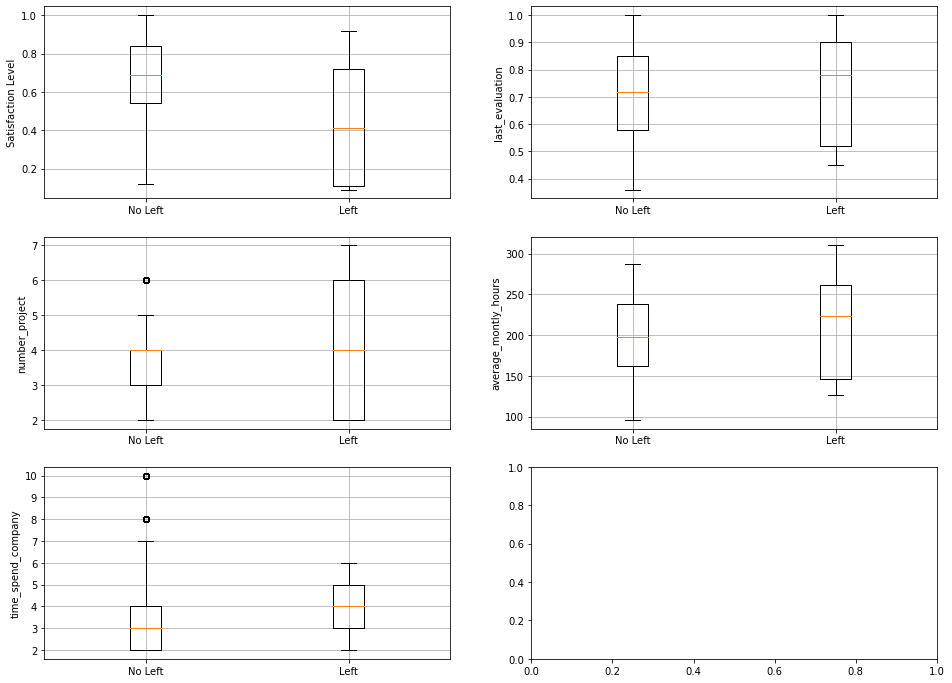

In [31]:
turnover_train = pd.concat([X_train, Y_train], axis = 1)

# Creating new figure
fig, axes = plt.subplots(3, 2, figsize = (16, 12))

# Subsetting the data
left = turnover_train[turnover_train['left'] == 1]
no_left = turnover_train[turnover_train['left'] == 0]

axes[0, 0].boxplot([no_left['satisfaction_level'], left['satisfaction_level']], labels = ['No Left', 'Left'])
axes[0, 0].set_ylabel('Satisfaction Level')
axes[0, 0].grid()

axes[0, 1].boxplot([no_left['last_evaluation'], left['last_evaluation']], labels = ['No Left', 'Left'])
axes[0, 1].set_ylabel('last_evaluation')
axes[0, 1].grid()

axes[1, 0].boxplot([no_left['number_project'], left['number_project']], labels = ['No Left', 'Left'])
axes[1, 0].set_ylabel('number_project')
axes[1, 0].grid()

axes[1, 1].boxplot([no_left['average_montly_hours'], left['average_montly_hours']], labels = ['No Left', 'Left'])
axes[1, 1].set_ylabel('average_montly_hours')
axes[1, 1].grid()

axes[2, 0].boxplot([no_left['time_spend_company'], left['time_spend_company']], labels = ['No Left', 'Left'])
axes[2, 0].set_ylabel('time_spend_company')
axes[2, 0].grid()

In [32]:
round(pd.crosstab(turnover_train['Work_accident'], turnover_train['left'], normalize = 'index'), 2)

left,0,1
Work_accident,,
0,0.74,0.26
1,0.92,0.08


In [34]:
turnover['salary'].value_counts()

low       7316
medium    6446
high      1237
Name: salary, dtype: int64

In [40]:
round(pd.crosstab(turnover_train['low'], turnover_train['left'], normalize = 'index'), 2)

left,0,1
low,,
0,0.82,0.18
1,0.70,0.30


In [41]:
round(pd.crosstab(turnover_train['medium'], turnover_train['left'], normalize = 'index'), 2)

left,0,1
medium,,
0,0.73,0.27
1,0.80,0.20


In [42]:
round(pd.crosstab(turnover_train['high'], turnover_train['left'], normalize = 'index'), 2)

left,0,1
high,,
0,0.75,0.25
1,0.94,0.06


In [44]:
round(pd.crosstab(turnover_train['sales'], turnover_train['left'], normalize = 'index'), 2)

left,0,1
sales,,
0,0.76,0.24
1,0.76,0.24


In [45]:
round(pd.crosstab(turnover_train['support'], turnover_train['left'], normalize = 'index'), 2)

left,0,1
support,,
0,0.76,0.24
1,0.75,0.25


In [46]:
round(pd.crosstab(turnover_train['hr'], turnover_train['left'], normalize = 'index'), 2)

left,0,1
hr,,
0,0.76,0.24
1,0.70,0.30


In [47]:
X_train_1 = X_train[['satisfaction_level', 'time_spend_company', 'low', 'medium', 'high', 'number_project', 'average_montly_hours']]
X_test_1 = X_test[['satisfaction_level', 'time_spend_company', 'low', 'medium', 'high', 'number_project', 'average_montly_hours']]

In [50]:
# Building Random Forest Model
rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train_1, Y_train)

# Predicting on test
rf_pred = rf_md.predict_proba(X_test_1)[:,1]

# Predicting the labels
rf_labels = precision_recall_cutoff.precision_recall_cutoff(Y_test, rf_pred)

# Printing classification report 
print(classification_report(Y_test, rf_labels))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2286
           1       0.75      0.89      0.82       714

    accuracy                           0.91      3000
   macro avg       0.86      0.90      0.88      3000
weighted avg       0.92      0.91      0.91      3000



In [51]:
# Building Adaboost Model
ada_md = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3), n_estimators = 500, learning_rate = 0.01).fit(X_train_1, Y_train)

# Predicting on test
ada_pred = ada_md.predict_proba(X_test_1)[:,1]

# Predicting the labels
ada_labels = precision_recall_cutoff.precision_recall_cutoff(Y_test, ada_pred)

# Printing classification report
print(classification_report(Y_test, ada_labels))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2286
           1       0.97      0.92      0.94       714

    accuracy                           0.97      3000
   macro avg       0.97      0.96      0.96      3000
weighted avg       0.97      0.97      0.97      3000



### Based on my results, I would choose AdaBoost Classifier model to perdict employee turnover.